# Basic object detection - Introduction
This is the third part of my [dezeenAI](https://github.com/adamsiemaszkiewicz/dezeenAI) project meant to build an object and colour detection search engine based on the [Dezeen.com](http://dezeen.com/)'s Interior category.

This notebook used YOLOv4 object detection system with the out-of-the-box classes and weights to tag the image dataset.

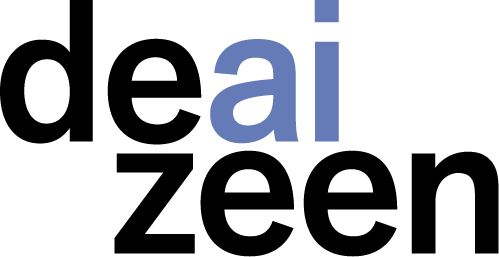

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/dezeenAI /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/dezeenAI': File exists
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


## Libraries & functions
- `cv2` - computer vision library
- `matplotlib.pyplot` - visualisation & plotting library
- `sys` - system-specific parameters and functions
- `os.path` - common pathname manipulations

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os.path
import pandas as pd
import numpy as np
import timeit
import tqdm.notebook as tq

#Darknet YOLOv4
YOLO (*You Only Look Once*) is an object detection system in real-time that recognizes various objects in a single enclosure. Currently it's one of the fastest and most precise object recognition systems.

Paper: [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934)

Code: [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet)

Medium article: [YOLOv4 — the most accurate real-time neural network on MS COCO dataset.](https://medium.com/@alexeyab84/yolov4-the-most-accurate-real-time-neural-network-on-ms-coco-dataset-73adfd3602fe)

## Clone the repository
Let's first clone the official Darknet repository.

In [4]:
# !git clone https://github.com/AlexeyAB/darknet

## GPU, OpenCV & CUDA
In order for the processing to run faster it's better to enable GPU acceleration within Colab notebook which will make the runtime 100 times faster. In order for Darknet to work propely we need to enable OpenCV and CUDA as well. To do so:

1. Navigate to `Edit -> Notebook settings -> Hardware Accelerator: GPU`
2. Use `sed -i` bash command to write some lines in-place to the `Makefile` to enable OpenCV, GPU and CUDNN.

In [5]:
# %cd /mydrive/darknet
# !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !sed -i 's/GPU=0/GPU=1/' Makefile
# !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

## Verify CUDA
CUDA is a parallel computing platform and application programming interface model created by Nvidia. It allows to use a CUDA-enabled graphics processing unit.

In [6]:
# !/usr/local/cuda/bin/nvcc --version

## Make Darknet
`make` command builds Darknet and creates executables to run or train object detectors

In [7]:
# !make

## Weights
YOLOv4 comes with pre-trained weights trained on 80 object categories of [MS COCO Dataset](https://cocodataset.org/) which is a good starting point for further development. Let's download them from the official Darknet repository using `wget`.

In [8]:
# !wget -nc https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

# Detection model

## Images DataFrame
Let's import the previously created DataFrame of images in the dataset.

In [9]:
# import the DataFrame
df = pd.read_csv('files/df_articles-images-downloaded.csv', index_col=0)

# reverse the order and reset index
df = df[::-1]
df.reset_index(drop=True, inplace=True)
df

,id,url,path
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg
...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...


## Helper functions

In [10]:
def displayImage(path):
  
  '''
  Takes the image path and displays it in the notebook.

  Parameters:
  path (str): A path to the image file

  Returns:
  Nothing
  '''

  # read the file
  image = cv2.imread(path)

  # resize the image
  height, width = image.shape[:2]
  resized_image = cv2.resize(
      image,
      (3*width, 3*height),
      interpolation = cv2.INTER_CUBIC
      )

  # set the figure
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis('off')

  # plot the image
  plt.imshow(
      cv2.cvtColor(
          resized_image,
          cv2.COLOR_BGR2RGB
          )
      )
  plt.show()

## Test
Darknet is now built and ready to run detections using YOLOv4 and pre-trained weights. It can already detect 80 classes of COCO Dataset. Let's test its performance on a pre-uploaded test picture.

- `./darknet detector test` - YOLOv4 detection function
- `coco.data` - dataset configuration
- `yolov4.cfg` - system architecture configuration
- `yolov4.weights` - pre-trained weights
- `-dont_show` - skips outputting the prediction picture (Notebook shows an error when trying to display the prediction) 
- `-tresh 0.5` - sets the treshold value for predictions

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
  

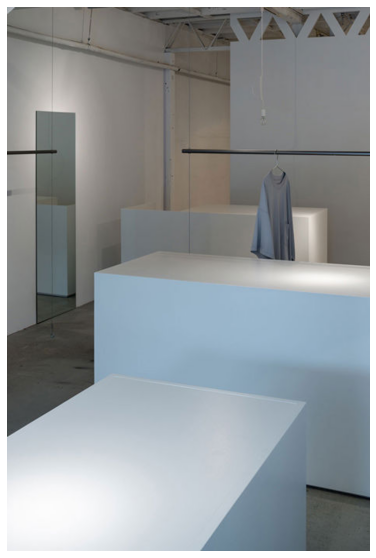

/content/gdrive/My Drive/Colab Notebooks/dezeenAI


In [11]:
# navigate to darknet directory
%cd darknet

# extract a random image path
path = df['path'][np.random.randint(0, df.shape[0])]

# make sure the permissions are ok
!chmod +x ./darknet

# run a YOLOv4 detector
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show -thresh 0.5 {path}

# show the image with object detection predictions
displayImage('predictions.jpg')

# navigate back to the working directory
%cd /mydrive

## Split dataset
Let's divide our dataset into smaller chunks to be able to do the predictions on smaller batches and save the list of split files into a list to iterate through later.

In [12]:
# navigate to files folder and create a temporary directory
%cd /mydrive/files
%mkdir -p tmp

# extract the list of filepaths
paths = df['path']

# set chunk size
chunksize = 2000

# iterate through chunks
for n in range(int(len(paths)/chunksize)+1):

  # set list slicing start and ending
  start = n * chunksize
  end = (n+1) * chunksize

  # detect if reaching end of dataset
  if end > len(paths): 
    end = len(paths)
  
  # set filename for each data chunk
  filename = 'dezeen_images-part{}.txt'.format(n+1)

  if os.path.isfile('tmp/' + filename):
    print('{}: file already exists! Continuing...'.format(filename))
  
  else:
    # save list of paths with each path in a new line
    content = '\n'.join(paths[start:end])
    f = open('tmp/'+filename, 'w')
    f.write(content)
    f.close()
    print('{}: file successfully saved.'.format(filename))

# navigate back to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files
dezeen_images-part1.txt: file already exists! Continuing...
dezeen_images-part2.txt: file already exists! Continuing...
dezeen_images-part3.txt: file already exists! Continuing...
dezeen_images-part4.txt: file already exists! Continuing...
dezeen_images-part5.txt: file already exists! Continuing...
dezeen_images-part6.txt: file already exists! Continuing...
dezeen_images-part7.txt: file already exists! Continuing...
dezeen_images-part8.txt: file already exists! Continuing...
dezeen_images-part9.txt: file already exists! Continuing...
dezeen_images-part10.txt: file already exists! Continuing...
dezeen_images-part11.txt: file already exists! Continuing...
dezeen_images-part12.txt: file already exists! Continuing...
dezeen_images-part13.txt: file already exists! Continuing...
dezeen_images-part14.txt: file already exists! Continuing...
dezeen_images-part15.txt: file already exists! Continuing...
dezeen_images-part16.txt: file already

## List of partial files
Let's create a lsit o partial file lists we've just created.


In [13]:
# navigate to the temporary directory
%cd /mydrive/files/tmp
# initiate a container
chunks = [] 

# iterate through all files in the directory
for filename in os.listdir(os.getcwd()):
  # if filename starts correctly, add it to the container
  if filename.startswith('dezeen_images-part'):
    chunks.append('/mydrive/files/tmp/'+filename)

# navigate back to the working directory
%cd /mydrive

chunks

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/files/tmp
/content/gdrive/My Drive/Colab Notebooks/dezeenAI


['/mydrive/files/tmp/dezeen_images-part1.txt',
 '/mydrive/files/tmp/dezeen_images-part2.txt',
 '/mydrive/files/tmp/dezeen_images-part3.txt',
 '/mydrive/files/tmp/dezeen_images-part4.txt',
 '/mydrive/files/tmp/dezeen_images-part5.txt',
 '/mydrive/files/tmp/dezeen_images-part6.txt',
 '/mydrive/files/tmp/dezeen_images-part7.txt',
 '/mydrive/files/tmp/dezeen_images-part8.txt',
 '/mydrive/files/tmp/dezeen_images-part9.txt',
 '/mydrive/files/tmp/dezeen_images-part10.txt',
 '/mydrive/files/tmp/dezeen_images-part11.txt',
 '/mydrive/files/tmp/dezeen_images-part12.txt',
 '/mydrive/files/tmp/dezeen_images-part13.txt',
 '/mydrive/files/tmp/dezeen_images-part14.txt',
 '/mydrive/files/tmp/dezeen_images-part15.txt',
 '/mydrive/files/tmp/dezeen_images-part16.txt',
 '/mydrive/files/tmp/dezeen_images-part17.txt',
 '/mydrive/files/tmp/dezeen_images-part18.txt',
 '/mydrive/files/tmp/dezeen_images-part19.txt',
 '/mydrive/files/tmp/dezeen_images-part20.txt',
 '/mydrive/files/tmp/dezeen_images-part21.txt',
 

## Scan dataset
Now, we can finally go through the image files in our dataset and detect objects in each of them. The results of the detection will be saved to the partial JSON files corresponding the partial lists from the previous step.

In [14]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few hours to complete...\n')

# navigate to YOLOv4 directory
%cd /mydrive/darknet
# make sure the permissions are ok
!chmod +x ./darknet

# initiate results container
results = []

# iterate through the partial files
for n, chunk in tq.tqdm(enumerate(chunks)):
  
  input = chunk
  # set the partial results filename
  output = '/mydrive/files/tmp/dezeen_results-part{}.json'.format(n+1)

  # add results path to the conntainer
  results.append(output)
  
  # check if file already exists
  if os.path.isfile(output):
    print('{}: file already exists! Continuing...'.format(output))
  # perform the object detection
  else:
    !./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -dont_show -ext_output -out {output} < {input}

# navigate back to the working directory
%cd /mydrive

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few hours to complete...

/content/gdrive/My Drive/Colab Notebooks/dezeenAI/darknet


/mydrive/files/tmp/dezeen_results-part1.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part2.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part3.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part4.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part5.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part6.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part7.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part8.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part9.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part10.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part11.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen_results-part12.json: file already exists! Continuing...
/mydrive/files/tmp/dezeen

# Update the DataFrame
Having the object detection results ready we can incorporate them into our DataFrame.

## Concatenate DataFrames
Let's import all results JSON files and concatenate them into one DataFrame using `pd.concat()`

In [15]:
# initiate empty DataFrame
results_df = pd.DataFrame()

# for each results file concatenate it to the DataFrame
for file in tq.tqdm(results):
  df_tmp = pd.read_json(file)
  results_df = pd.concat([results_df, df_tmp])

# rename the column
results_df.rename(columns={'filename': 'path'}, inplace=True)

# drop unnecessary column and reset index
results_df.drop(['frame_id'], axis=1, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# navigate back to the working directory
%cd /mydrive

results_df


/content/gdrive/My Drive/Colab Notebooks/dezeenAI


,path,objects
0,/mydrive/data/dezeen/15/k.jpg,[]
1,/mydrive/data/dezeen/15/q.jpg,"[{'class_id': 56, 'name': 'chair', 'relative_c..."
2,/mydrive/data/dezeen/15/c.jpg,[]
3,/mydrive/data/dezeen/15/b.jpg,[]
4,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[{'class_id': 71, 'name': 'sink', 'relative_co..."
...,...,...
47224,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 59, 'name': 'bed', 'relative_coo..."
47225,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 75, 'name': 'vase', 'relative_co..."
47226,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 62, 'name': 'tvmonitor', 'relati..."
47227,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 58, 'name': 'pottedplant', 'rela..."


## Classes
Let's pick the classes we want our object detection system to recognize.

### COCO-default
First, let's retrieve the names of official COCO dataset classes.

In [16]:
with open('/mydrive/darknet/cfg/coco.names') as fp:
  data = fp.read() 

coco_classes = data.split('\n')[:-1] # slice to get rid of final empty row
coco_classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

### Architecture related
Then, based on the original list, let's only pick the ones which has anything to do with interior architecture.

In [17]:
classes = [
           'person',
           'bicycle',
           'car',
          #  'motorbike',
          #  'aeroplane',
          #  'bus',
          #  'train',
          #  'truck',
          #  'boat',
          #  'traffic light',
          #  'fire hydrant',
          #  'stop sign',
          #  'parking meter',
           'bench',
          #  'bird',
           'cat',
           'dog',
          #  'horse',
          #  'sheep',
          #  'cow',
          #  'elephant',
          #  'bear',
          #  'zebra',
          #  'giraffe',
          #  'backpack',
          #  'umbrella',
          #  'handbag',
          #  'tie',
          #  'suitcase',
          #  'frisbee',
          #  'skis',
          #  'snowboard',
           'sports ball',
          #  'kite',
          #  'baseball bat',
          #  'baseball glove',
           'skateboard',
          #  'surfboard',
          #  'tennis racket',
           'bottle',
           'wine glass',
           'cup',
           'fork',
           'knife',
           'spoon',
           'bowl',
          #  'banana',
          #  'apple',
          #  'sandwich',
          #  'orange',
          #  'broccoli',
          #  'carrot',
          #  'hot dog',
          #  'pizza',
          #  'donut',
          #  'cake',
           'chair',
           'sofa',
           'pottedplant',
           'bed',
           'diningtable',
           'toilet',
           'tvmonitor',
           'laptop',
          #  'mouse',
          #  'remote',
           'keyboard',
          #  'cell phone',
           'microwave',
           'oven',
          #  'toaster',
           'sink',
           'refrigerator',
           'book',
           'clock',
           'vase',
          #  'scissors',
          #  'teddy bear',
          #  'hair drier',
          #  'toothbrush'
           ]

## Extract classes & confidences values
Having the objects detected in the form of a list let's extract each recognized objects and detection confidence values

In [18]:
def extractClassQuantityConfidence(objects, class_name):
  
  '''
  Takes the list of objects, checks if a specified class name is present in the list
  and outputs a corresponding boolean and confidence values.

  Parameters:
  objects (list): Results list of recognized objects
  class_name (str): Name of a class

  Returns:
  Boolean value (True/False)
  '''

  # set default values
  conf = []
  number = 0

  # iterate through list objects
  for obj in objects:
    # check if matches and update values
    if obj['name'] == class_name:
      conf.append(obj['confidence'])
      number =+ 1
      break

  if number > 0: 
    # calculate mean average confidence
    conf_avg = np.mean(np.array(conf))
  
  else: conf_avg = 0

  return number, conf_avg

In [19]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few seoncds to complete...\n')

# iterate through name of classes
for cls in tq.tqdm(classes):
  
  # extract classes
  results_df[cls] = results_df.apply(lambda x: extractClassQuantityConfidence(x['objects'], cls)[0], axis=1)

  # extract confidence
  results_df[cls+'_conf'] = results_df.apply(lambda x: extractClassQuantityConfidence(x['objects'], cls)[1], axis=1)

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('Runtime: {} seconds.'.format(int(stop-start)))

results_df


Starting. This might take a few seoncds to complete...




Runtime: 33 seconds.


,path,objects,person,person_conf,bicycle,bicycle_conf,car,car_conf,bench,bench_conf,cat,cat_conf,dog,dog_conf,sports ball,sports ball_conf,skateboard,skateboard_conf,bottle,bottle_conf,wine glass,wine glass_conf,cup,cup_conf,fork,fork_conf,knife,knife_conf,spoon,spoon_conf,bowl,bowl_conf,chair,chair_conf,sofa,sofa_conf,pottedplant,pottedplant_conf,bed,bed_conf,diningtable,diningtable_conf,toilet,toilet_conf,tvmonitor,tvmonitor_conf,laptop,laptop_conf,keyboard,keyboard_conf,microwave,microwave_conf,oven,oven_conf,sink,sink_conf,refrigerator,refrigerator_conf,book,book_conf,clock,clock_conf,vase,vase_conf
0,/mydrive/data/dezeen/15/k.jpg,[],0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
1,/mydrive/data/dezeen/15/q.jpg,"[{'class_id': 56, 'name': 'chair', 'relative_c...",0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.350172,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
2,/mydrive/data/dezeen/15/c.jpg,[],0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
3,/mydrive/data/dezeen/15/b.jpg,[],0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
4,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,"[{'class_id': 71, 'name': 'sink', 'relative_co...",0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.259822,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,0.32862,0,0.0,0,0.0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47224,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 59, 'name': 'bed', 'relative_coo...",0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.491402,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.445811,1,0.363451,0,0.000000,1,0.579165,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47225,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 75, 'name': 'vase', 'relative_co...",0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.925025,0,0.000000,1,0.790885,0,0.000000,1,0.252753,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,1,0.661205
47226,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 62, 'name': 'tvmonitor', 'relati...",0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.343536,0,0.0,0,0.0,0,0.0,1,0.641778,1,0.972639,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,1,0.886706,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47227,/mydrive/data/dezeen/1596617/napier-street-mil...,"[{'class_id': 58, 'name': 'pottedplant', 'rela...",0,0.0,0,0.0,1,0.998821,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,1,0.267047,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000


In [20]:
# objects_df = df.merge(results_df, on='path', how='left')
objects_df = df.merge(results_df, left_index=True, right_index=True)
objects_df.drop(['objects'], axis=1, inplace=True)
# objects_df.drop_duplicates(subset=['path', 'url'], inplace=True)
objects_df

,id,url,path_x,path_y,person,person_conf,bicycle,bicycle_conf,car,car_conf,bench,bench_conf,cat,cat_conf,dog,dog_conf,sports ball,sports ball_conf,skateboard,skateboard_conf,bottle,bottle_conf,wine glass,wine glass_conf,cup,cup_conf,fork,fork_conf,knife,knife_conf,spoon,spoon_conf,bowl,bowl_conf,chair,chair_conf,sofa,sofa_conf,pottedplant,pottedplant_conf,bed,bed_conf,diningtable,diningtable_conf,toilet,toilet_conf,tvmonitor,tvmonitor_conf,laptop,laptop_conf,keyboard,keyboard_conf,microwave,microwave_conf,oven,oven_conf,sink,sink_conf,refrigerator,refrigerator_conf,book,book_conf,clock,clock_conf,vase,vase_conf
0,15,http://static.dezeen.com/uploads/2006/11/k.jpg,/mydrive/data/dezeen/15/k.jpg,/mydrive/data/dezeen/15/k.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
1,15,http://static.dezeen.com/uploads/2006/11/q.jpg,/mydrive/data/dezeen/15/q.jpg,/mydrive/data/dezeen/15/q.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.350172,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
2,15,http://static.dezeen.com/uploads/2006/11/c.jpg,/mydrive/data/dezeen/15/c.jpg,/mydrive/data/dezeen/15/c.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
3,15,http://static.dezeen.com/uploads/2006/11/b.jpg,/mydrive/data/dezeen/15/b.jpg,/mydrive/data/dezeen/15/b.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
4,15,https://static.dezeen.com/uploads/2006/11/1dez...,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,/mydrive/data/dezeen/15/1dezeen_november-07.jpg,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.259822,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,1,0.32862,0,0.0,0,0.0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47224,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.491402,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.445811,1,0.363451,0,0.000000,1,0.579165,0,0.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47225,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.925025,0,0.000000,1,0.790885,0,0.000000,1,0.252753,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,1,0.661205
47226,1596617,https://static.dezeen.com/uploads/2020/12/napi...,/mydrive/data/dezeen/1596617/napier-street-mil...,/mydrive/data/dezeen/1596617/napier-street-mil...,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.343536,0,0.0,0,0.0,0,0.0,1,0.641778,1,0.972639,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.0,1,0.886706,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000
47227,1596617,https://static.dezeen.com/uploads/2020/12/napi..

## Export the DataFrame

In [21]:
# increase the maximum depth of the Python interpreter to avoid an overflow error
sys.setrecursionlimit(10000)

# export
objects_df.to_csv('files/images_objectsbasic.csv')